In [1]:
import pandas as pd
import numpy as np
import string
import os
import time
from keras.applications.inception_v3 import InceptionV3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_doc(file_name):
    file = open(file_name, 'r',encoding="utf8")
    #read all text
    text = file.read()
    file.close()
    return text

file_name = "/content/drive/MyDrive/NLP/BT_TH2/Flickr8k.token_VN.txt"
doc = load_doc(file_name)
print(doc[:300])

1000268201_693b08cb0e.jpg # 0 Một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.
1000268201_693b08cb0e.jpg # 1 Một cô gái đi vào một tòa nhà bằng gỗ.
1000268201_693b08cb0e.jpg # 2 Một cô bé trèo vào nhà chơi bằng gỗ.
1000268201_693b08cb0e.jpg # 3 Một cô bé leo lên cầu thang đến nh


In [6]:
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        # image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8121 


In [ ]:
descriptions['1000268201_693b08cb0e.jpg']

['# 0 Một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.',
 '# 1 Một cô gái đi vào một tòa nhà bằng gỗ.',
 '# 2 Một cô bé trèo vào nhà chơi bằng gỗ.',
 '# 3 Một cô bé leo lên cầu thang đến nhà chơi của mình.',
 '# 4 Một cô bé mặc váy hồng đi vào cabin gỗ.']

In [7]:
# lọc ra các image ko có trong flickr8k
path = "/content/drive/MyDrive/NLP/BT_TH2/Images"
lst_image = os.listdir(os.path.expanduser(path))
descriptions2 = descriptions.copy()
i=0
lst_none = []

for i in descriptions2:
    if i not in lst_image:
        del descriptions[i]
    else:
        pass
for i in range(len(lst_image)):
  if lst_image[i] not in descriptions.keys():
    lst_none.append(lst_image[i])

for j in lst_none:
  lst_image.remove(j)
print('Loaded: %d ' % len(lst_image))
print('Loaded: %d ' % len(descriptions))

Loaded: 7938 
Loaded: 7938 


In [10]:
# Xử lý văn bản
def clean_descriptions(descriptions):
# chuẩn bị bảng dịch để xóa câu
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # chuyển về chữ thường
            desc = [word.lower() for word in desc]
            # xóa dấu chấm câu
            desc = [w.translate(table) for w in desc]
            # xóa các kí tự
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] = 'startseq ' + ' '.join(desc) + ' endseq'

# clean descriptions
clean_descriptions(descriptions)

In [9]:
# sau khi xử lý
descriptions['1000268201_693b08cb0e.jpg']

['startseq một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào endseq',
 'startseq một cô gái đi vào một tòa nhà bằng gỗ endseq',
 'startseq một cô bé trèo vào nhà chơi bằng gỗ endseq',
 'startseq một cô bé leo lên cầu thang đến nhà chơi của mình endseq',
 'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq']

In [ ]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()

save_descriptions(descriptions, '/content/drive/MyDrive/NLP/BT_TH2/descriptions.txt')

# Sau khi xử lý làm sạch trên, tiếp theo gọi dữ liệu làm sạch ra để cb train model


In [ ]:
file_name = "/content/drive/MyDrive/NLP/BT_TH2/descriptions.txt"
doc = load_doc(file_name)
print(doc[:800])

1000268201_693b08cb0e.jpg startseq một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào endseq
1000268201_693b08cb0e.jpg startseq một cô gái đi vào một tòa nhà bằng gỗ endseq
1000268201_693b08cb0e.jpg startseq một cô bé trèo vào nhà chơi bằng gỗ endseq
1000268201_693b08cb0e.jpg startseq một cô bé leo lên cầu thang đến nhà chơi của mình endseq
1000268201_693b08cb0e.jpg startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq
1001773457_577c3a7d70.jpg startseq một con chó đen và một con chó đốm đang chiến đấu endseq
1001773457_577c3a7d70.jpg startseq một con chó đen và một con chó ba màu đang chơi với nhau trên đường endseq
1001773457_577c3a7d70.jpg startseq một con chó đen và một con chó trắng có đốm nâu đang nhìn chằm chằm vào nhau trên đường phố endseq
1001773457_577c3a7d70.


In [ ]:
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 7938 


In [ ]:
# kiểm tra đã đúng chưa
descriptions['1001773457_577c3a7d70.jpg']

['startseq một con chó đen và một con chó đốm đang chiến đấu endseq',
 'startseq một con chó đen và một con chó ba màu đang chơi với nhau trên đường endseq',
 'startseq một con chó đen và một con chó trắng có đốm nâu đang nhìn chằm chằm vào nhau trên đường phố endseq',
 'startseq hai con chó thuộc các giống khác nhau nhìn nhau trên đường endseq',
 'startseq hai con chó trên vỉa hè di chuyển về phía nhau endseq']

In [ ]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
# Load ảnh, resize về khích thước mà Inception v3 yêu cầu.
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x) # xử lý để tương thích với model sử dụng
    return x

# Load the inception v3 model

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 0s 0us/step


In [ ]:
#Tạo model mới bỏ layer cuối từ inception v3
from tensorflow import keras
model_new = keras.Model(model.input, model.layers[-2].output)

In [ ]:
#Image embedding thành vector(2048, )
def encode(img):
  image2 = preprocess(img) # preprocess the image
  fea_vec = model_new.predict(image2) # get the encoding vector for the image
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from(1,2048)
  return fea_vec

In [ ]:
encode('/content/drive/MyDrive/NLP/BT_TH2/Images/1001773457_577c3a7d70.jpg')

array([0.73668396, 0.5911319 , 0.18194209, ..., 0.16030227, 0.34144711,
       0.9083158 ], dtype=float32)

# Encode image

In [ ]:
print(len(lst_image))

7938


In [ ]:
# # đã xử lý
# path ='/content/drive/MyDrive/NLP/BT_TH2/Images/'

# encoding_test = {}
# for img in lst_image:
#   encoding_test[img] = encode(path+img)


In [ ]:
# #đã xử lý
# from pickle import dump
# # Save the bottleneck test features to disk
# with open("/content/drive/MyDrive/NLP/BT_TH2/encoded_images.pkl", "wb") as encoded_:
#     dump(encoding_test, encoded_)

In [ ]:
from pickle import load
image_features = load(open("/content/drive/MyDrive/NLP/BT_TH2/encoded_images.pkl", "rb"))
print('Photos: train=%d' % len(image_features))

Photos: train=7938


#Tạo ma trận embedding

In [ ]:
!pip install underthesea

     |████████████████████████████████| 7.6 MB 7.0 MB/s 
     |████████████████████████████████| 581 kB 42.2 MB/s 
     |████████████████████████████████| 965 kB 49.1 MB/s 
     |████████████████████████████████| 235 kB 66.5 MB/s 


In [ ]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
descriptions_line = to_lines(descriptions)

# def max_length(descriptions_line):
#     return max(len(d.split()) for d in descriptions_line)

# max_length = max_length(descriptions_line)
# print('Description Length: %d' % max_length)

In [ ]:
from underthesea import word_tokenize
def create_stopwords(path):
  with open(path, encoding='utf-8') as words:
    return [w[:len(w) - 1] for w in words]
stopwords = create_stopwords('/content/drive/MyDrive/NLP/BT_TH_1/vietnamese-stopwords.txt')

In [ ]:

def word_processing(descriptions_line_sequence):
  sentence = [word for word in word_tokenize(descriptions_line_sequence.lower(), format='text').split() if word not in stopwords]
  return [word for word in sentence if word != ""]

In [ ]:
input_sentences = [word_processing(str(sentence)) for sentence in descriptions_line]

In [ ]:
input_sentences[:10]

[['startseq',
  'đứa',
  'trẻ',
  'mặc',
  'váy',
  'hồng',
  'trèo',
  'cầu_thang',
  'lối',
  'endseq'],
 ['startseq', 'gái', 'đi', 'tòa', 'gỗ', 'endseq'],
 ['startseq', 'bé', 'trèo', 'gỗ', 'endseq'],
 ['startseq', 'bé', 'leo', 'cầu_thang', 'endseq'],
 ['startseq', 'bé', 'mặc', 'váy', 'hồng', 'đi', 'cabin', 'gỗ', 'endseq'],
 ['startseq', 'chó', 'đen', 'chó', 'đốm', 'chiến_đấu', 'endseq'],
 ['startseq', 'chó', 'đen', 'chó', 'màu', 'đường', 'endseq'],
 ['startseq',
  'chó',
  'đen',
  'chó',
  'trắng',
  'đốm_nâu',
  'chằm_chằm',
  'đường_phố',
  'endseq'],
 ['startseq', 'hai', 'chó', 'đường', 'endseq'],
 ['startseq', 'hai', 'chó', 'vỉa_hè', 'di_chuyển', 'endseq']]

In [ ]:
word2id = dict()
max_words = 0 # maximum numbẻ of words in a sentence

for sentence in input_sentences:
  for word in sentence:
    if word not in word2id:
      word2id[word] = len(word2id)
  if len(sentence) > max_words:
    max_words = len(sentence)
  
  # Construction of label2id and id2label dicts

  id2word = {v: k for k,v in word2id.items()}

In [ ]:
print(max_words)
print(id2word[5])
vocab_size = len(id2word)
max_length = max_words
print('Vocab_size: ',vocab_size)

26
hồng
Vocab_size:  5318


In [ ]:
from gensim.models import KeyedVectors
word_2_vec_model_path = '/content/drive/MyDrive/NLP/BT_TH_1/baomoi.vn.model.bin'
embedding_index = KeyedVectors.load_word2vec_format(word_2_vec_model_path, binary=True) # dạng bin nên format binary true

In [ ]:
# Chuẩn bị embedding matrix
max_word = 100000
words_not_found_vector = []
words_not_found = []
embedding_dim = 300 # Dimension of word_embeddings
num_word = min(max_word,len(word2id)) # tổng số lượng từ thấp nhất

# Với mỗi từ trong câu lưu lại word vector phụ để huấn luyện mô hình (embedding vector)
embedding_matrix = np.zeros((num_word, embedding_dim))
for word, i in word2id.items(): # lấy ra key và value
  if i >= num_word:
    continue
  try:
  # model_embedding chứa giá trị xác suất của từ liên quan 
    embedding_vector = embedding_index[word] # model_embedding là embedding_index chứa các index
  except:
    words_not_found_vector.append(word) # Do lấy min_count=2 nên có thể chủ nghĩa tình hình có 1 nên bị loại bỏ
  try:
    if (embedding_vector is not None) and len(embedding_vector) > 0: # word có
      embedding_matrix[i] = embedding_vector
    else: # word ko có từ liên quan trong embedding_vector
      words_not_found.append(word)
  except:
    continue
print('words không tìm thấy các từ liên quan trong vector: ', words_not_found)
print('words không tìm thấy các từ liên quan trong w2id: ', words_not_found_vector)

words không tìm thấy các từ liên quan trong vector:  []
words không tìm thấy các từ liên quan trong w2id:  ['startseq', 'endseq', 'vẫy_tay', 'frolicks', 'crampon', 'túp_lều', 'đằng_xa', 'phòng_tối', 'bulgie', 'anouther', 'áo_sơ_mi', 'jumphouse', 'rappel', 'spelunkers', 'cắm_trại', 'vâng_lời', 'phát_sáng', 'xe_trượt_tuyết', 'nâu_đen', 'nằm_ngửa', 'cỏ_khô', 'cờ_đen', 'ghế_xếp', 'quần_hồng', 'blond', 'đồ_uống', 'mái_che', 'nhăn_mặt', 'vẻ_ngoài', 'bloe', 'xe_tay', 'duỗi_ra', 'hậu_cảnh', 'mạn_thuyền', 'binky', 'lốm_đốm_nâu', 'cau_mày', 'dây_phơi', 'sủi_bọt', 'dây_buộc', 'thức_uống', 'playpen', 'waterskier', 'fayre', 'kéo_cờ', 'con_bọ', 'hộp_đêm_tối', 'rộng_thùng_thình', 'cạo_đầu', 'mù_sương', 'hiệu_thuốc', 'cạo_trọc', 'hiker', 'khăn_quàng_cổ', 'cột_điện', 'hộp_sọ', 'dập_tắt', 'súng_phun', 'carjack', 'khô_cạn', 'đỉnh_đầu', 'bmxer', 'hiviz', 'patrickance', 'đeo_đai', 'chậu_hoa', 'gokarts', 'lộn_ngược', 'waterski', 'sòng_bạc', 'quán_rượu', 'innertube', 'ống_bơm', 'kéo_lê', 'che_mắt', 'oppsite'

#**Tạo model chính**

In [ ]:
# Tạo model chính
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras import Input, layers
from keras.layers.merge import add
# Nhánh 1. Input image vector
inputs_image = Input(shape=(2048,))
drop_1 = Dropout(0.5)(inputs_image)
fc_1 = Dense(256, activation='relu')(drop_1)

# Nhánh 2. Input câu mô tả
inputs_desc = Input(shape=(max_length,))
emb_1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs_desc)
drop_2 = Dropout(0.5)(emb_1)
lstm_1 = LSTM(256)(drop_2)

# Gộp 2 input
decoder_1 = add([fc_1, lstm_1])
fc_3 = Dense(256, activation='relu')(decoder_1)

# Layer output
outputs = Dense(vocab_size, activation='softmax')(fc_3)
model = Model(inputs=[inputs_image, inputs_desc], outputs=outputs)

# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 300)      1595400     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

#Data generation

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#Train test split

In [ ]:
s = pd.Series(descriptions)
s

1000268201_693b08cb0e.jpg    [startseq một đứa trẻ mặc váy hồng đang trèo l...
1001773457_577c3a7d70.jpg    [startseq một con chó đen và một con chó đốm đ...
1002674143_1b742ab4b8.jpg    [startseq một cô bé được phủ sơn ngồi trước cầ...
1003163366_44323f5815.jpg    [startseq một người đàn ông nằm trên băng ghế ...
1007129816_e794419615.jpg    [startseq một người đàn ông đội mũ màu cam đan...
                                                   ...                        
990890291_afc72be141.jpg     [startseq một người đàn ông lái xe lăn trên vỉ...
99171998_7cc800ceef.jpg      [startseq một nhóm đang ngồi quanh một đường n...
99679241_adc853a5c0.jpg      [startseq một con chim màu xám đứng uy nghi tr...
997338199_7343367d7f.jpg     [startseq một người đứng gần những bức tường v...
997722733_0cb5439472.jpg     [startseq một người đàn ông mặc áo hồng trèo l...
Length: 7938, dtype: object

In [ ]:
s2 = s[:3000]
s2

1000268201_693b08cb0e.jpg    [startseq một đứa trẻ mặc váy hồng đang trèo l...
1001773457_577c3a7d70.jpg    [startseq một con chó đen và một con chó đốm đ...
1002674143_1b742ab4b8.jpg    [startseq một cô bé được phủ sơn ngồi trước cầ...
1003163366_44323f5815.jpg    [startseq một người đàn ông nằm trên băng ghế ...
1007129816_e794419615.jpg    [startseq một người đàn ông đội mũ màu cam đan...
                                                   ...                        
2832978253_8fcc72da3b.jpg    [startseq một người leo núi leo lên một ngọn đ...
2833431496_09d999db4d.jpg    [startseq một cậu bé và một cô gái đang cúi xu...
2833560457_24aedf3bef.jpg    [startseq một con chó màu be và trắng đang chạ...
2833582518_074bef3ed6.jpg    [startseq một con chó chạy xuống đường ray bụi...
2833820456_143ea6ce47.jpg    [startseq một cô gái sắp ăn dưa hấu và uống nư...
Length: 3000, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
train , test  = [i.to_dict() for i in train_test_split(s2, train_size=0.7)]

In [ ]:
train_image_features = image_features.copy()
list_train_keys = list(train.keys())
for i in image_features:
  # print(i)
    if i not in list_train_keys:
      # print(i)
      del train_image_features[i]
    else:
      pass


In [ ]:
len(train_image_features)

2100

In [ ]:
test_image_features = image_features.copy()
list_test_keys = list(test.keys())
for i in image_features:
  # print(i)
    if i not in list_test_keys:
      # print(i)
      del test_image_features[i]
    else:
      pass


In [ ]:
len(test_image_features)

900

#Train model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
# Cài đặt tham số train và TRAIN!!!
model.optimizer.lr= 0.0001
epochs = 10 # Số epoch
number_pics_per_batch = 6 # Số lượng ảnh mỗi batch
steps = len(descriptions)//number_pics_per_batch # Số bước mỗi epoch

# Train nào
for i in range(epochs):
    generator = data_generator(train, train_image_features, word2id, max_words, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Sau 10 bước train ta lưu weights
model.save_weights('/content/drive/MyDrive/NLP/BT_TH2/model_30.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


1323/1323 [==============================] - 590s 446ms/step - loss: 2.4181


In [ ]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word2id[w] for w in in_text.split() if w in word2id]
        # print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        # print(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = id2word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

2381102729_12fc4d4c76.jpg


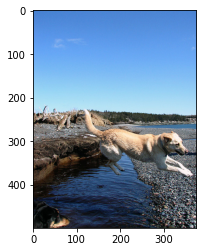

Tôi nghĩ bức ảnh này là: 
chó màu nâu chạy bãi biển
0.5318295896944989


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
images = '/content/drive/MyDrive/NLP/BT_TH2/Images/'
z=450
pic = list(test_image_features.keys())[z]
print(pic)
imagess =  test_image_features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(u"Tôi nghĩ bức ảnh này là: ")
print(greedySearch(imagess))
image_id =pic.split('.')[0]
score = sentence_bleu([image_id], greedySearch(imagess))
print(score)

In [ ]:
test_image_features

{'1000268201_693b08cb0e.jpg': array([0.12277616, 0.33294937, 0.7527171 , ..., 0.21939719, 0.30216435,
        0.40283197], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([0.373519  , 0.24596593, 0.9635306 , ..., 1.1459359 , 0.26540142,
        0.01983146], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.17231025, 0.49808335, 0.21576974, ..., 0.09676231, 1.2298498 ,
        0.54214156], dtype=float32),
 '1019077836_6fc9b15408.jpg': array([0.34666276, 0.43228957, 0.2574394 , ..., 0.325281  , 0.42775902,
        0.44598764], dtype=float32),
 '1022454428_b6b660a67b.jpg': array([0.4963346 , 0.19245875, 0.401637  , ..., 0.93441904, 0.7397396 ,
        0.06167346], dtype=float32),
 '102351840_323e3de834.jpg': array([0.10465112, 0.2057387 , 0.19238435, ..., 0.15708345, 0.43167943,
        0.26807672], dtype=float32),
 '1032460886_4a598ed535.jpg': array([0.5906359 , 0.08231199, 0.5957172 , ..., 0.27855572, 0.40730214,
        0.17353703], dtype=float32),
 '1042590306_95dea0916c.jpg'

# Chia tập train và test

In [ ]:
train = descr